# Données antipathiques (skewed), Appariement (correction)

Correction pour des données antipathiques.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Description du problème

*Les corrections (exos 3 et 5) seront explicitées dans un autre notebook.*

On se place ici dans le cadre d'un problème classique désigné par le terme anglais de [conflation](https://en.wikipedia.org/wiki/Conflation) (voir aussi [Conflation Optimized by Least Squares to Maintain Geographic Shapes](http://www.mdpi.com/2220-9964/2/3/621). Il s'agit de fusionner deux bases de données qui décrivent chacune les mêmes entités (deux annuaires par exemple) mais de manière légèrement différentes.

Par exemple, on dispose de deux bases $B_1$ et $B_2$. Chacune d'elles donne les positions géographiques de $N_1$ et $N_2$ bâtiments. La mesure des coordonnées est faite à dix ans d'intervalles et on souhaite connaître les bâtiments qui ont été détruits ou créés. Il faut donc apparier les $N_1$ entités de la première base avec les $N_2$ de la seconde.

Une première option consiste à calculer toutes les distances entre les deux bases soit $N_1 N_2$ distances puis à apparier les deux points les plus proches, puis les deux suivantes les plus proches jusqu'à ce qu'on décide qu'à partir d'un certain seuil, deux bâtiments sont probablement trop éloignés pour être appariés.

Lorsqu'on dispose de grandes bases, 10 millions d'entités par exemple, ce calcul devient impossible à réaliser en un temps raisonnable. Il faut ruser.

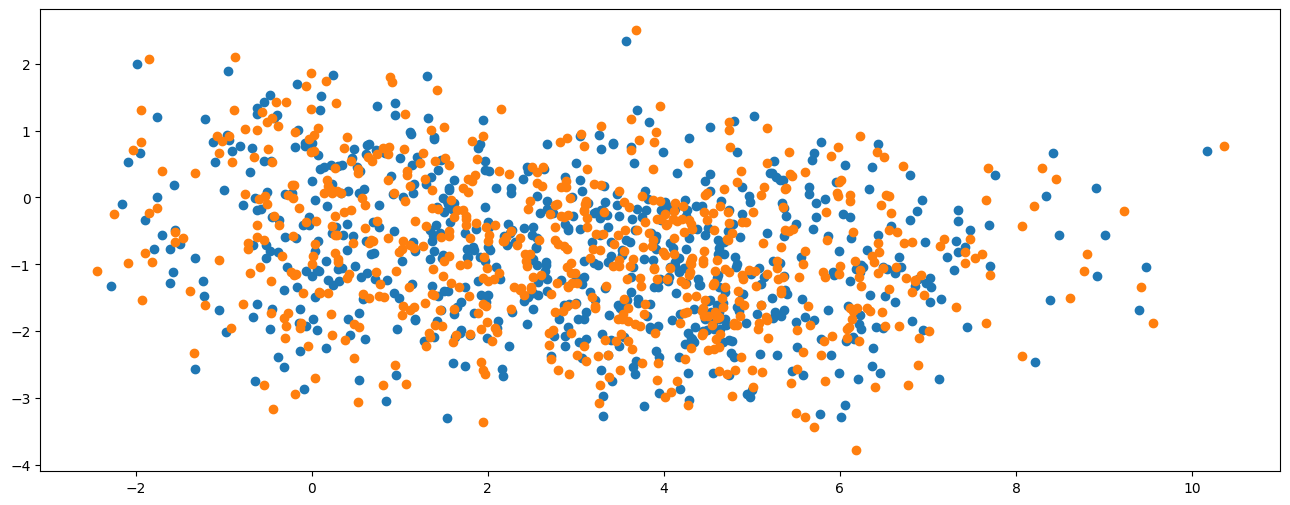

In [2]:
import random

x1 = [random.gauss(0, 1) for i in range(0, 150)] + [
    random.gauss(0, 1) * 2 + 4 for i in range(0, 500)
]
y1 = [random.gauss(0, 1) for i in range(0, 150)] + [
    random.gauss(0, 1) - 1 for i in range(0, 500)
]
x2 = [x + random.gauss(0, 0.2) for x in x1]
y2 = [y + random.gauss(0, 0.2) for y in y1]
plt.figure(figsize=(16, 6))
plt.plot(x1, y1, "o")
plt.plot(x2, y2, "o");

On veut apparier les points bleus et rouges. Si on dessine une grille sur les données, deux points ont plus de chance d'être appariés s'ils font partie de la même case. Mais cela ne suffit pas. Il faut aussi considérer les voisins.

## Exercice 1 : combien de voisins faut-il considérer ?

On suppose que deux points $P_i$ (rouge) et $Q_j$ (bleu) ne peuvent jamais être appariés si la distance $dist( P_i,Q_j) > h$. Le point $P_i=(x_1^i,y_1^i)$ est dans la $c_1^i=(k_1^i,l_1^i)$. Où peut-être $Q_j$ ?

$Q_j$ est soit dans la case $c_1^i$ soit dans un de ses huit voisins. D'après l'hypothèse citée ci-dessus, si on sait dans quel quart le point $P_i$ se trouve, on pourrait réduire ce nombre à 3. On définit $M = \max card(c_i)$, c'est-à-dire le plus grand nombre de points dans une case. Pour chaque point, il va falloir regarder toutes les paires entre $P_i$ et tous les points dans les neuf cases adjacentes. On peut majorer cela par $9M_1$. Le nombre de paires à comparer devient $9 M_1 N_2$.

## Exercice 2 : nombre de distances ?

On trace la courbe du nombre de paires en fonction de la taille des cases.

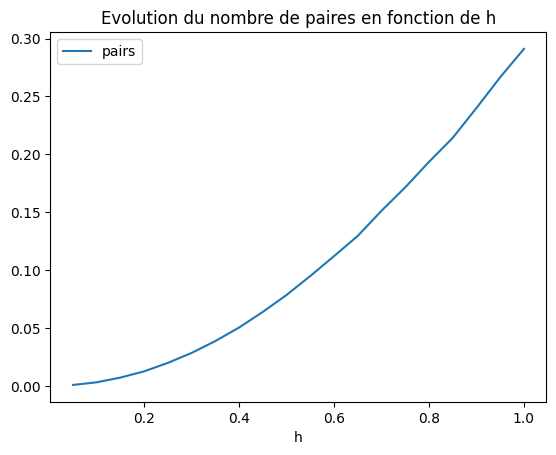

In [3]:
import pandas


def tableau(x1, y1, x2, y2):
    rows = []
    for wh in range(1, 21):
        H = W = wh / 20

        # étape 1 : on indexe les points Q2
        index = {}
        for x, y in zip(x2, y2):
            p, q = int(x / W), int(y / H)
            if (p, q) not in index:
                index[p, q] = []
            index[p, q].append((x, y))

        # étape 2 : on parcourt le premier ensemble
        pairs = 0
        for x, y in zip(x1, y1):
            p, q = int(x / W), int(y / H)
            neighbours = [(p + i, q + j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
            for n in neighbours:
                if n in index:
                    pairs += len(index[n])
        rows.append({"h": W, "pairs": pairs / (len(x1) * len(x2))})
    df = pandas.DataFrame(rows)
    return df


df = tableau(x1, y1, x2, y2)
ax = df.plot(x="h", y="pairs")
ax.set_title("Evolution du nombre de paires en fonction de h");

Cette courbe dépend fortement de la distribution initiale des points. On change la fonction pour calculer l'appariement et on conserver les indices des points.

In [4]:
def distance(x, y, xx, yy):
    return (x - xx) ** 2 + (y - yy) ** 2


def tableau(set1, set2):
    rows = []
    H = W = 0.4

    # étape 1 : on indexe les points Q2
    index = {}
    for j, x, y in set2:
        p, q = int(x / W), int(y / H)
        if (p, q) not in index:
            index[p, q] = []
        index[p, q].append((j, x, y))

    # étape 2 : on parcourt le premier ensemble
    pairs = []
    for i, x, y in set1:
        p, q = int(x / W), int(y / H)
        neighbours = [(p + i, q + j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
        for n in neighbours:
            if n in index:
                for j, xx, yy in index[n]:
                    pairs.append((distance(x, y, xx, yy), i, j))

    return pairs


def appariement(pairs):
    done1 = {}
    done2 = {}
    res = []
    for d, i, j in pairs:
        if i not in done1 and j not in done2:
            res.append((i, j))
            done1[i] = i
            done2[j] = j
    return res


def appariement_complet(set1, set2):
    pairs = tableau(set1, set2)
    pairs.sort()
    res = appariement(pairs)
    return res, pairs


set1 = [(i, p[0], p[1]) for i, p in enumerate(zip(x1, y1))]
set2 = [(i, p[0], p[1]) for i, p in enumerate(zip(x2, y2))]
res, pairs = appariement_complet(set1, set2)
print("len(set1) =", len(set1), "len(set2) =", len(set2))
print("len(pairs) =", len(pairs), "len(res) =", len(res))

len(set1) = 650 len(set2) = 650
len(pairs) = 21293 len(res) = 628


L'appariement n'est ni optimal ni complet (voir [couplage optimal dans un graphe bi-parti](https://fr.wikipedia.org/wiki/Graphe_biparti)). Mais l'objectif n'est pas là. Il s'agit de distribuer cette méthode simple.

In [5]:
%timeit appariement_complet(set1, set2)

17.6 ms ± 592 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Exercice 3 : distribuer les calculs
    
La première fonction revient à calculer toutes les paires. Son implémentation en python utilise un index ce qui psoe problème en  Map/Reduce. Il faut également éviter d'accumuler des données ou de les compter car cela n'est pas facilement distribuable. On réécrit la fonction différemment en python en tenant compte de ces deux contraintes avant de passer à map/reduce. Le plus sûr pour cela est d'utiliser des itérateurs et de ne pas créer de listes ou de dictionnaires. 

In [6]:
def tableau_iterateur(set1, set2):
    # Cette version est moins efficace car elle fait plus
    # de comparaisons inutiles.
    H = W = 0.4
    for i, x1, y1 in set1:  # join
        p1, q1 = int(x1 / W), int(y1 / H)
        for j, x2, y2 in set2:  # join
            p2, q2 = int(x2 / W), int(y2 / H)
            if abs(p1 - p2) <= 1 and abs(q1 - q2) <= 1:
                yield (distance(x1, y1, x2, y2), i, j)


def appariement_iterateur(pairs):
    done1 = {}
    done2 = {}
    for d, i, j in pairs:  # map
        if i not in done1 and j not in done2:
            done1[i] = i
            done2[j] = j
            yield i, j


def appariement_complet_iterateur(set1, set2):
    pairs = sorted(tableau_iterateur(set1, set2))
    res = appariement_iterateur(pairs)
    return res, pairs


set1 = [(i, p[0], p[1]) for i, p in enumerate(zip(x1, y1))]
set2 = [(i, p[0], p[1]) for i, p in enumerate(zip(x2, y2))]
iter_res, iter_pairs = appariement_complet_iterateur(set1, set2)

res = list(iter_res)
pairs = list(iter_pairs)

print("len(set1) =", len(set1), "len(set2) =", len(set2))
print("len(pairs) =", len(pairs), "len(res) =", len(res))

len(set1) = 650 len(set2) = 650
len(pairs) = 21678 len(res) = 634


In [7]:
%timeit list(appariement_complet_iterateur(set1, set2)[0])

113 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


La nouvelle version est beaucoup moins efficace car elle fait de nombreuses comparaisons inutiles évitées par les lignes relatives à l'étape 1 mais elle est plus facile à paralléliser car elle ne regrouper pas les point dans des clusters communs.

## Exercice 4 : données antipathiques

Utiliser une grille pour réduire le nombre de paires à évaluer. Cela fonctionne bien si le nuage est à peu près dense de la même façon partout. Mais si on imagine un nuage de points beaucoup plus dense dans une certaine région, la grille sera moins efficace.

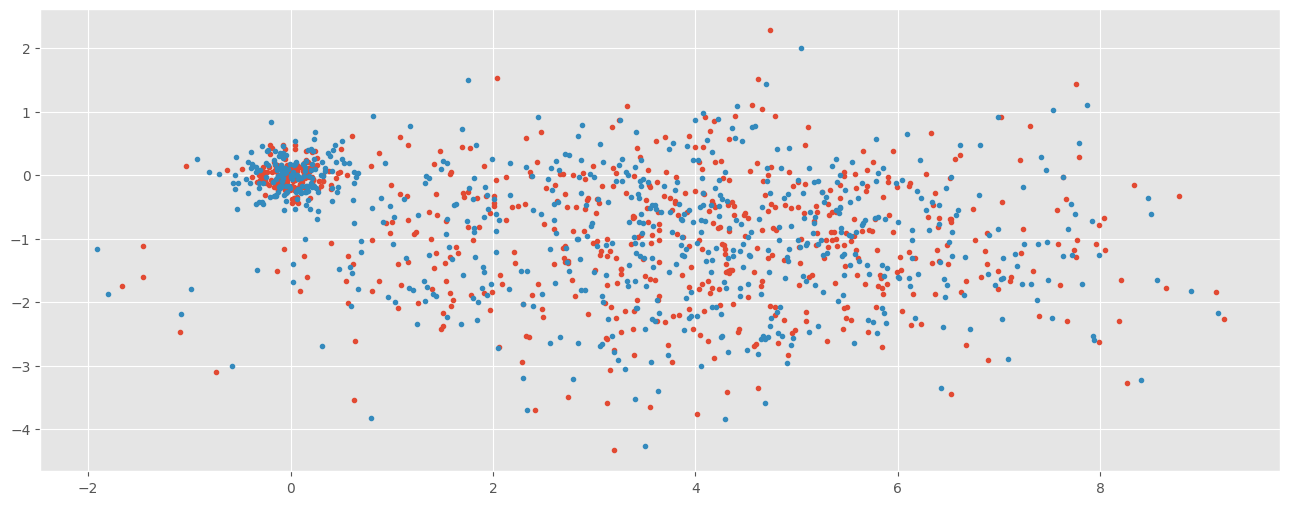

In [6]:
import random

x1 = [random.gauss(0, 1) * 0.2 for i in range(0, 150)] + [
    random.gauss(0, 1) * 2 + 4 for i in range(0, 500)
]
y1 = [random.gauss(0, 1) * 0.2 for i in range(0, 150)] + [
    random.gauss(0, 1) - 1 for i in range(0, 500)
]
x2 = [x + random.gauss(0, 0.2) for x in x1]
y2 = [y + random.gauss(0, 0.2) for y in y1]
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(x1, y1, ".")
plt.plot(x2, y2, ".");

On appelle ce genre de dataset un [skewed dataset](http://www.mathsisfun.com/data/skewness.html). Le problème est décrit ici : [Skewed Join Optimization](https://cwiki.apache.org/confluence/display/Hive/Skewed+Join+Optimization). La fonction ``tableau_iterateur`` réalise une opérateur ``JOIN`` qui s'opère sur les coordonnées de la case : la clé. On peut distribuer les clés mais pas les observations rattachées à la même clé. Lorsque des clés aggrègent beaucoup d'observations, il devient plus difficile de les distribuer.

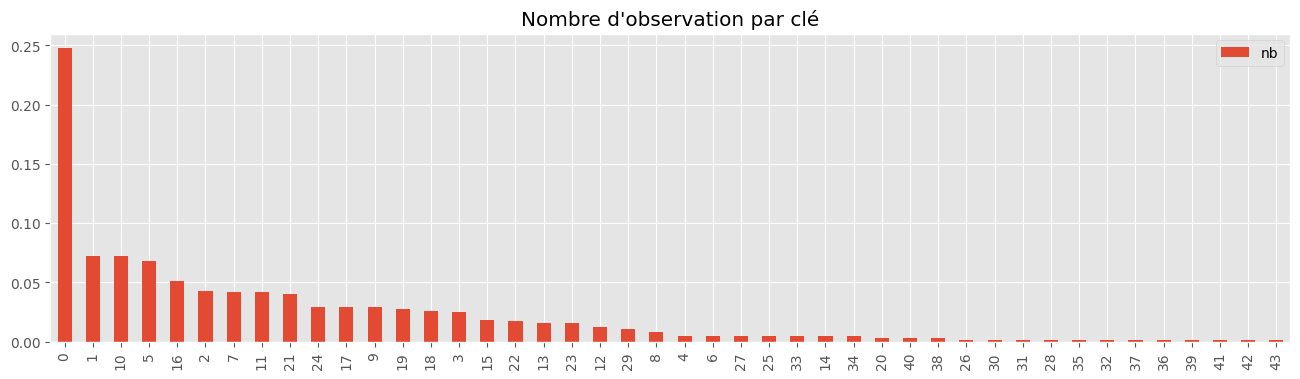

In [7]:
W = H = 1
set1 = [(i, p[0], p[1]) for i, p in enumerate(zip(x1, y1))]
index = {}
for j, x, y in set1:
    p, q = int(x / W), int(y / H)
    if (p, q) not in index:
        index[p, q] = 0
    index[p, q] += 1

df = pandas.DataFrame(
    [{"cle": i, "nb": kv[1] / len(set1)} for i, kv in enumerate(index.items())]
).sort_values("nb", ascending=False)
ax = df.plot(y="nb", kind="bar", figsize=(16, 4))
ax.set_title("Nombre d'observation par clé");

Si on distribue ce dataset sur plus de 5 machines, toutes les machines auront terminé alors que celle traitant la clé la plus représentée continuera de traiter les observations associées à cette clé.

## Exercice 5 : comment distribuer malgré tout ?

Oublions le problème initial. On a deux datasets qu'on doit fusionner (*JOIN*). Une des clés est partagée par plus de 10% des deux bases. Comment distribuer ce *JOIN* sur plusieurs machines ? On écrit la solution d'abord en Python. On réduit l'étude des paires de points qui se trouvent dans la même case.

In [8]:
def tableau_iterateur(set1, set2):
    for i, x1, y1, key1 in set1:
        for j, x2, y2, key2 in set2:
            if key1 == key2:
                yield (distance(x1, y1, x2, y2), i, j)


H = W = 0.4
set1 = [
    (i, p[0], p[1], (int(p[0] / W), int(p[1] / H))) for i, p in enumerate(zip(x1, y1))
]
set2 = [
    (j, p[0], p[1], (int(p[0] / W), int(p[1] / H))) for i, p in enumerate(zip(x2, y2))
]

# on restreint à la clé en question
set1_00 = [(i, x, y, key) for i, x, y, key in set1 if key == (0, 0)]
set2_00 = [(i, x, y, key) for i, x, y, key in set2 if key == (0, 0)]

l = list(tableau_iterateur(set1_00, set2_00))
print("len(l) =", len(l), "len(set1_00) * len(set2_00) =", len(set1_00) * len(set2_00))

len(l) = 15070 len(set1_00) * len(set2_00) = 15070


En suppose que le *JOIN* sera distribué sur 10 machines, l'idée est d'envoyer un ensemble ``set1`` sur les 10 machines et un dixième de l'autre sur les 10 machines.

In [9]:
def tableau_iterateur_split(set1, set2):
    for i, x1, y1, key1 in set1:
        for j, x2, y2, key2 in set2:
            if (
                key1 == key2
            ):  # le cas d'inégalité correspond à un cas qui disparaît lors de la distribution
                yield (distance(x1, y1, x2, y2), i, j, key1, key2)


import random

set1_spl = [(i, x, y, key + (k,)) for i, x, y, key in set1_00 for k in range(0, 10)]
set2_spl = [(i, x, y, key + (random.randint(0, 9),)) for i, x, y, key in set2_00]

l = list(tableau_iterateur_split(set1_spl, set2_spl))
print(
    "len(l) =", len(l), "len(set1_spl) * len(set2_spl) =", len(set1_spl) * len(set2_spl)
)

len(l) = 15070 len(set1_spl) * len(set2_spl) = 150700


On obtient le même nombre de paires à la fin. Qu'a-t-on gagné ? C'est difficile à dire. Certes, le calcul a été distribué mais il a fallu envoyer une des deux tables à toutes les machines. Le coût de transmission peut se révéler assez fort à moins que le coût de la fonction ``distance`` le fasse oublier.

La solution la plus simple et la plus efficace consiste à utiliser un *JOIN* particuler : [Skewed Joins](https://pig.apache.org/docs/r0.11.1/perf.html#skewed-joins). Ces opérations changent la façon dont sont distribuées les clés. La table *skewed* est parcouru une première fois pour construire la distribution. Les clés sont ensuite réparties en évitant de surcharger les machines qui traitent les clés sur-représentées. 